# Map out D3D-100 Dataset

We map out the D3D-100 Dataset. This consists of 100 non-disruptive and 100 disruptive shots.

In [1]:
# Import system libraries
import logging
from os import environ
from os.path import join

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import sys

import matplotlib.pyplot as plt

In [2]:
# Import frnn-loader libraries
sys.path.append("/home/rkube/repos/frnn-loader")
from frnn_loader.backends.fetchers import fetcher_d3d_v1
from frnn_loader.backends.backend_hdf5 import backend_hdf5
from frnn_loader.primitives.filters import filter_ip_thresh
from frnn_loader.primitives.resamplers import resampler_causal
from frnn_loader.primitives.signal import signal_0d
from frnn_loader.primitives.normalizers import mean_std_normalizer
from frnn_loader.loaders.frnn_dataset_disk import shot_dataset_disk
from frnn_loader.loaders.frnn_multi_dataset import frnn_multi_dataset
from frnn_loader.loaders.frnn_loader import batched_random_sequence_sampler


from frnn_loader.utils.errors import SignalCorruptedError, NotDownloadedError

In [3]:
# Directory where all project data files are to be stored
root = "/projects/FRNN/frnn_loader"
root_shotlists = "/home/rkube/repos/shot_lists"

# 1/ Describe the dataset
predictor_tags = [
    "q95",
    "efsli",
    "ipspr15V",
    "efsbetan",
    "efswmhd",
    "dssdenest",
    "pradcore",
    "pradedge",
    "bmspinj",
    "bmstinj",
    "ipsiptargt",
    "ipeecoil",
]
predictor_list = [signal_0d(tag) for tag in predictor_tags]

# Contains a list of shots that are non-disruptive
shotlist_clear = "d3d_clear_100.txt"
# Contains a list of shots that are disruptive
shotlist_disrupt = "d3d_disrupt_100.txt"

In [21]:
# Instantiate the filter we use to crimp the shot times
ip_filter = filter_ip_thresh(0.2)
signal_ip = signal_0d("ipspr15V")
my_backend = backend_hdf5(root)
my_fetcher = fetcher_d3d_v1()

# These shots don't have enough data and are unusable
# Several of them are also not disruptive but die to to carbon motes or other hardware failures
skip_shots = [167495, 167515, 167548, 167549, 167567, 167568, 167569, 167570, 168439, 168450, 168451, 168483, 168484, 168485, 168486, 168487, 168488, 168490, 168491, 168500]

In [22]:
# Load clear shots

shotdict = {}

with open(join(root_shotlists, shotlist_clear), "r") as fp:
    for line in tqdm(fp.readlines()):
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        
        # Run the Ip filter over the current shot.
        # For this we need the shot raw-data. Ask the backend to load it.
        try:
            tb, signal_data = my_backend.load(signal_ip.info, shotnr)
        except NotDownloadedError:
            # If data is not downloaded a NotDownloadedError is thrown.
            # Then use the fetcher to manually download it
            tb, _, signal_data, _, _, _ = my_fetcher.fetch(signal_ip.info, shotnr)
            my_backend.store(signal_ip.info, shotnr, tb, signal_data)
        # Some shots in d3d_clear_100 have no plasma. Skip these shots.
        if shotnr in skip_shots:
            continue
            
        try:
            tmin, tmax = ip_filter(tb, signal_data)
        except SignalCorruptedError as err:
            #print(f"--- Shot {shotnr}: Error: ", err)
            skip_shots.append(shotnr)
            continue
            
        shotdict.update(
            {
                shotnr: {
                    "tmin": tmin,
                    "tmax": tmax,
                    "is_disruptive": False,
                    "t_disrupt": -1.0,
                }
            }
        )
        
print(f"Skipping shots {skip_shots}")   

100%|████████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 91.65it/s]

Skipping shots [167495, 167515, 167548, 167549, 167567, 167568, 167569, 167570, 168439, 168450, 168451, 168483, 168484, 168485, 168486, 168487, 168488, 168490, 168491, 168500]


In [23]:
with open(join(root_shotlists, shotlist_disrupt), "r") as fp:
    for line in tqdm(fp.readlines()):
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        
        # Run the Ip filter over the current shot.
        # For this we need the shot raw-data. Ask the backend to load it.
        try:
            tb, signal_data = my_backend.load(signal_ip.info, shotnr)
        except NotDownloadedError:
            # IF it's now downloaded a NotDownloadedError is thrown.
            # Then use the fetcher to manually download it
            tb, _, signal_data, _, _, _ = my_fetcher.fetch(signal_ip.info, shotnr)
            my_backend.store(signal_ip.info, shotnr, tb, signal_data)
        
        if shotnr in skip_shots:
            continue
        # ttd is given in seconds in the text files. Convert it to milliseconds
        ttd = ttd * 1e3
        shotdict.update(
            {
                shotnr: {
                    "tmin": tmin,
                    "tmax": ttd,
                    "is_disruptive": True,
                    "t_disrupt": ttd,
                }
            }
        )


100%|███████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 207.14it/s]


In [24]:
#########################################################################################################
#
# Next we create a list of datasets for all shots.
# The shots are cut to the time intervals defined by tmin and tmax
# A normalizer is calculated from these datasets.
# After the normalizer has been calculated the hdf5 files generated by
# these dataset are to be deleted using ds.delete_data_file

dset_unnormalized_list = []
for shotnr in tqdm(shotdict.keys()):
    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=None,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32)

    dset_unnormalized_list.append(ds)

100%|██████████████████████████████████████████████████████████████████████████| 175/175 [02:07<00:00,  1.38it/s]


In [62]:
dset_unnormalized = frnn_multi_dataset(dset_unnormalized_list)
len(dset_unnormalized)

175

In [128]:
#########################################################################################################
#
# With all datasets cropped to the correct time in place we continue by calculating the normalization.
# Do this using multi-processing
my_normalizer = mean_std_normalizer()
my_normalizer.fit(dset_unnormalized_list)

print(my_normalizer.mean_all)
print(my_normalizer.std_all)

tensor([ 5.5644e+00,  1.0407e+00,  1.2602e+00,  1.1864e+00,  4.3677e+05,
         3.0795e+00,  1.5054e-03,  7.8101e-04,  4.0467e+03,  2.6515e+00,
         1.9533e+00, -3.5190e-02])
tensor([2.3636e+00, 2.0160e+00, 1.5722e+00, 9.7465e-01, 3.2553e+05, 1.5153e+00,
        1.8123e-03, 9.2141e-04, 2.8216e+03, 2.4814e+00, 6.1482e-01, 1.1702e-01])


In [129]:
# With a normalizer at hand, we can now safely delete the datafiles from the
# un-normalized shots.
# Then re-instantiate the datasets using the trained normalizer
dset_normalized_list = []
for shotnr in tqdm(shotdict.keys()):

    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=my_normalizer,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32,
    )
    dset_normalized_list.append(ds)

dset_work = frnn_multi_dataset(dset_normalized_list)

100%|██████████████████████████████████████████████████████████████████████████| 175/175 [02:11<00:00,  1.33it/s]


In [37]:
type(dset_work[0].predictors[0])

frnn_loader.primitives.signal.signal_0d

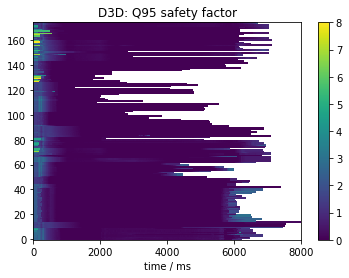

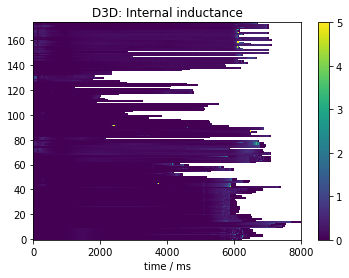

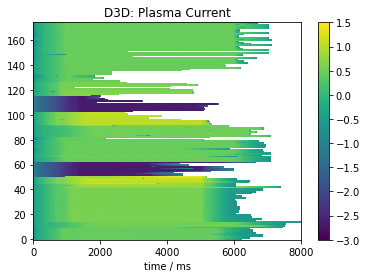

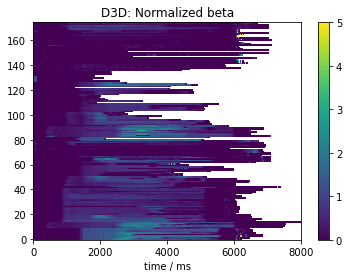

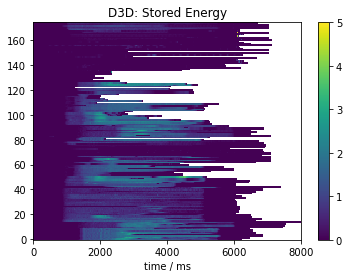

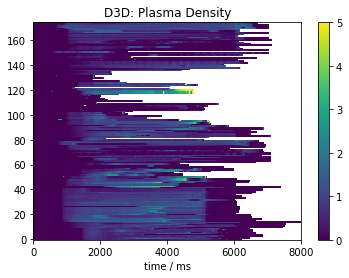

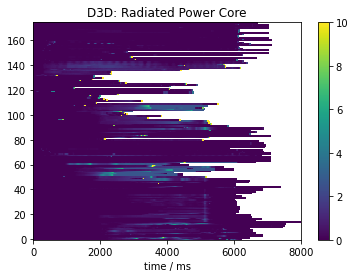

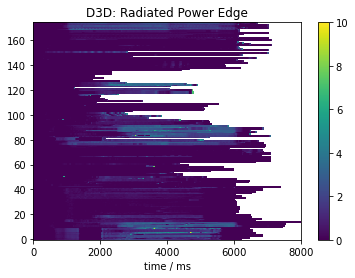

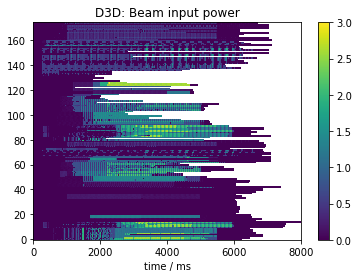

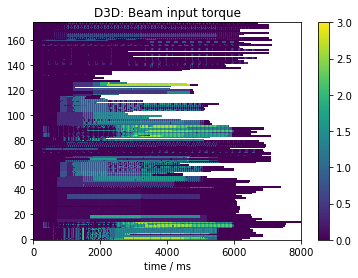

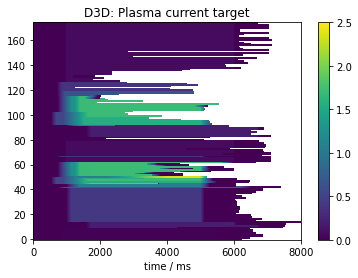

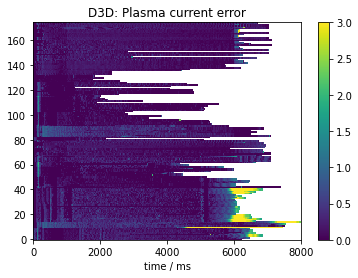

In [135]:
# Calculate length of the individual shots and allocate storage array for plotting
n_sample = 10

max_len = -1
for ds in dset_work:
    max_len = max(max_len, len(ds))
max_len = max_len + 3

# Generate time-base for plotting
trg = np.arange(0, max_len)

# Color limits for predictors
v_list = [(0.0, 8.0), #q95
          (0.0, 5.0), #ali
          (-3.0, 1.5), #Ip,
          (0.0, 5.0), #beta
          (0.0, 5.0), #wmhd
          (0.0, 5.0), #density
          (0.0, 10.0), #pradcode
          (0.0, 10.0), #pradedge
          (0.0, 3.0), #pinj
          (0.0, 3.0), #tinj
          (0.0, 2.5), #ip target
          (0.0, 3.0) #ip error
         ]

# Store plot data in MaskedArray
# Later down, matplotlib will put while pixels where missing data is indicated
tmp_array = np.ma.MaskedArray(np.zeros([len(dset_work), max_len]), mask=np.array(np.zeros([len(dset_unnormalized), max_len]), dtype=bool))

for pred_idx, pred in enumerate(dset_work[0].predictors):
    # Fill plot data and mark missing data (At time inideces the shot has already finished)
    for idx in range(len(dset_unnormalized)):
        data = dset_work[idx][:][0][:, pred_idx].numpy()
        nelem = data.size
        #print(nelem, tmp_array[idx, :nelem].shape, data[:nelem].shape)
        tmp_array[idx, :nelem] = data[:nelem]
        tmp_array.mask[idx, nelem:] = True

    vmin, vmax = v_list[pred_idx]

    plt.figure()
    plt.pcolor(trg[::n_sample], np.arange(len(dset_unnormalized)), tmp_array[:, ::n_sample], 
               vmin=vmin, vmax=vmax)
    plt.xlabel("time / ms")
    plt.colorbar()
    plt.title(pred.__str__())
    plt.savefig(f"D3D_100_predictor_{pred_idx}.png")
    